In [1]:
!pip install colormath

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for colormath: filename=colormath-3.0.0-py3-none-any.whl size=39408 sha256=85ded3f38d3bd075a2935b717a45bd62c78d3f4735fd0a8d7a5cf74f698d029f
  Stored in directory: /root/.cache/pip/wheels/1a/d7/a7/458a4632ccc8bfe436f5e9db9fef1aa84e5d243a1b4b4c7b59
Successfully built colormath


MOUNT THE DRIVE AND LOAD THE DATASET

In [2]:
import os
import sys
import PIL.Image as Image
import matplotlib.pyplot as plt
import torchvision.transforms as tr

from colormath.color_objects import LCHabColor, sRGBColor
from colormath.color_conversions import convert_color

In [3]:
import torch
import torch.nn as nn
from torchsummary import summary
import torchvision.transforms as tr
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os

import numpy as np

In [4]:
#general variables
n_epochs=5
cycle_lambda = 10.
root_data = "lch_database"

In [5]:
# pour monter son drive Google Drive local
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
my_local_drive='/content/gdrive/My Drive/Colab Notebooks/harmonie/CycleGAN'
# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
%cd $my_local_drive

%pwd
%ls

/content/gdrive/My Drive/Colab Notebooks/harmonie/CycleGAN
'archive(4).zip'
'Copy of cycleGAN_CH.ipynb'
 cycleGAN_CH_loadAndRun.ipynb
 CycleGAN.ipynb
 cycleGAN_patches.ipynb
 for_patches.jpg
 for_test_2.png
 for_test.png
 lch_database/
 lch_harmonies_dataset/
 LCH_UTILS.ipynb
 Models/
 notebooks_utils/
 not_so_straight_and_narrow_by_organicvision_degbboy-fullview.jpg
 result_analog.png
 winter_summer_dataset/


In [7]:
def lch_to_rgb(img,wasByte):
  new_img = np.zeros(img.shape)
  ctr=0
  if img.shape[2]!=3:
    print("warning : image is not in :,:,3 format !")
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      pixel = img[i,j]
      lch = LCHabColor(pixel[0],pixel[1],pixel[2]/(256./360) if wasByte else pixel[2])
      rgb = convert_color(lch,sRGBColor)
      new_img[i,j]=np.array([rgb.rgb_r,rgb.rgb_g,rgb.rgb_b])
      ctr+=1
      if ctr%10000==0:
        print("converting image to rgb, did",ctr,"pixels")
  return new_img

def rgb_to_lch(img,forModel):
  new_img = np.zeros(img.shape)
  ctr=0
  if img.shape[2]!=3:
    print("warning : image is not in :,:,3 format !")
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      pixel = img[i,j]
      rgb = sRGBColor(pixel[0]/255.,pixel[1]/255.,pixel[2]/255.)
      lch = convert_color(rgb,LCHabColor)
      new_img[i,j]=np.array([lch.lch_l,lch.lch_c,lch.lch_h*(256./360) if forModel else lch.lch_h])
      ctr+=1
      if ctr%10000==0:
        print("converting image to lch, did",ctr,"pixels")
  return new_img

#MODELS

on a besoin des classes des modèles pour charger le type de modèle que j'ai enregistré. Si on veut faire sans la classe, on peut enregistrer une autre version mais ça prend bcp de place (j'ai vu jusqu'à 256Mo)

In [11]:
from torch.nn.modules.instancenorm import InstanceNorm2d
class Block(nn.Module):
  def __init__(self,in_chan,out_chan,stride,padding):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_chan,out_chan,4,stride,padding,padding_mode="reflect"),
        nn.InstanceNorm2d(out_chan),
        nn.LeakyReLU(0.2)
    )
  
  def forward(self,X):
    return self.conv(X)

In [12]:
class convBlock(nn.Module):
  def __init__(self,in_channels,out_channels,use_act=True,down=True,**kwargs):
    super().__init__()
    self.block=nn.Sequential(
        nn.Conv2d(in_channels,out_channels,**kwargs)
        if down else
        nn.ConvTranspose2d(in_channels,out_channels,**kwargs),
        nn.InstanceNorm2d(out_channels),
        nn.ReLU() if use_act else nn.Identity()
    )

  def forward(self,x):
    return self.block(x)

In [13]:
class residualBlock(nn.Module):
  def __init__(self,n_channels):
    super().__init__()
    self.block = nn.Sequential(
        convBlock(n_channels,n_channels,kernel_size=3,stride=1,padding=1),
        convBlock(n_channels,n_channels,False,kernel_size=3,stride=1,padding=1)
    )
  def forward(self,x):
    return x + self.block(x)

In [14]:
class Generator(nn.Module):
  def __init__(self,n_residuals=9,in_channels=3,num_features=64):
    super().__init__()
    self.initial = nn.Sequential(
        nn.Conv2d(in_channels,num_features,7,1,3,padding_mode="reflect"),
        nn.ReLU()
        )
    self.down = nn.ModuleList(
        [
        convBlock(num_features,num_features*2,kernel_size=3,stride=2,padding=1),
        convBlock(num_features*2,num_features*4,kernel_size=3,stride=2,padding=1)
        ]
    )
    self.residual=nn.ModuleList(
        [*[residualBlock(num_features*4) for _ in range(n_residuals)]
        ]
    )
    self.up = nn.ModuleList(
        [
        convBlock(num_features*4,num_features*2,kernel_size=3,stride=2,padding=1,output_padding=1,down=False),
        convBlock(num_features*2,num_features*1,kernel_size=3,stride=2,padding=1,output_padding=1,down=False)
        ]
    )
    self.up.append(nn.Sequential(
        nn.Conv2d(num_features,2,7,1,3,padding_mode="reflect"),
        nn.Tanh()
        )
    )

  def forward(self,x):
    x = self.initial(x)
    for d in self.down:
      x = d(x)
    for r in self.residual:
      x = r(x)
    for u in self.up:
      x = u(x)
    return x

In [15]:
%ls

'archive(4).zip'
'Copy of cycleGAN_CH.ipynb'
 cycleGAN_CH_loadAndRun.ipynb
 CycleGAN.ipynb
 cycleGAN_patches.ipynb
 for_patches.jpg
 for_test_2.png
 for_test.png
 lch_database/
 lch_harmonies_dataset/
 LCH_UTILS.ipynb
 Models/
 notebooks_utils/
 not_so_straight_and_narrow_by_organicvision_degbboy-fullview.jpg
 result_analog.png
 winter_summer_dataset/


#saving and loading

(pour choisir l'image à donner en rgb, changer l'input de Image.open())

In [16]:
the_model = Generator(n_residuals=3,num_features=64)
the_model.load_state_dict(torch.load("Models/rect"))
the_model = the_model.to(torch.device("cuda:0"))

In [17]:
img = np.array(Image.open("for_test_2.png"))
img_lch = rgb_to_lch(img,True)/255.

converting image to lch, did 10000 pixels
converting image to lch, did 20000 pixels
converting image to lch, did 30000 pixels
converting image to lch, did 40000 pixels
converting image to lch, did 50000 pixels
converting image to lch, did 60000 pixels


In [18]:
img_lch = torch.Tensor(np.moveaxis(img_lch,-1,0)).to(torch.device("cuda:0"))

converting image to rgb, did 10000 pixels
converting image to rgb, did 20000 pixels
converting image to rgb, did 30000 pixels
converting image to rgb, did 40000 pixels
converting image to rgb, did 50000 pixels
converting image to rgb, did 60000 pixels
converting image to rgb, did 10000 pixels
converting image to rgb, did 20000 pixels
converting image to rgb, did 30000 pixels
converting image to rgb, did 40000 pixels
converting image to rgb, did 50000 pixels
converting image to rgb, did 60000 pixels


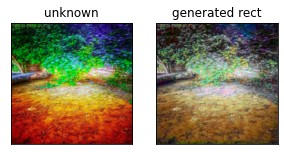

In [19]:
plt.figure(figsize=(10,10))

plt.subplot(1,4,3)
rgb_img = lch_to_rgb(np.moveaxis(np.array(img_lch.cpu()),0,-1)*255.,True)
plt.imshow(rgb_img)
plt.title("unknown")
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)

plt.subplot(1,4,4)
genImg = the_model(img_lch)
genImg = np.array(torch.cat([img_lch[0,:,:].reshape((1,256,256)),genImg],axis=0).cpu().detach())
rgb_img = lch_to_rgb(np.moveaxis(genImg,0,-1)*255.,True)
plt.imshow(rgb_img)
plt.title("generated rect")
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)

In [20]:
#prevent modulo clipping by doing normal clipping by hand
for line in rgb_img:
  for pixel in line:
    for a in pixel:
      a = a if a>0 else 0
      a = a if a<255 else 255
      if a>255 or a<0:
        print("clipping failed")

#save image
PIL_img = Image.fromarray((rgb_img*255.).astype(np.uint8))
PIL_img.save("result_analog.png")